# Compare finite differences vs analytic Fisher

In this notebook we compare on the example of a DES Y1 analysis a Fisher matrix obtained by finite differences of CCL computations with 
a Fisher matrix obtained by autodiff with jax-cosmo.


In [62]:
%pylab inline
import os.path
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import pyccl as ccl

Populating the interactive namespace from numpy and matplotlib


## Setting up the analysis

In this first section, we load the redshift distributions of the DES Y1 
and we define a few configurations

In [4]:
# Let's retrieve the nz data
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

--2020-07-26 19:12:02--  http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits
Resolving desdr-server.ncsa.illinois.edu (desdr-server.ncsa.illinois.edu)... 141.142.161.38
Connecting to desdr-server.ncsa.illinois.edu (desdr-server.ncsa.illinois.edu)|141.142.161.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6600960 (6.3M) [application/octet-stream]
Saving to: ‘2pt_NG_mcal_1110.fits’

2pt_NG_mcal_1110.fi 100%[===================>]   6.29M  1.33MB/s    in 4.7s    

2020-07-26 19:12:07 (1.33 MB/s) - ‘2pt_NG_mcal_1110.fits’ saved [6600960/6600960]



In [63]:
# Turn these redsfhit distributions into a slightly more computer friendly format
zs = nz_source['Z_MID']
zl = nz_lens['Z_MID']
nzs = [ nz_source['BIN%d'%(i+1)] for i in range(4)]
nzl = [ nz_lens['BIN%d'%(i+1)] for i in range(5)]

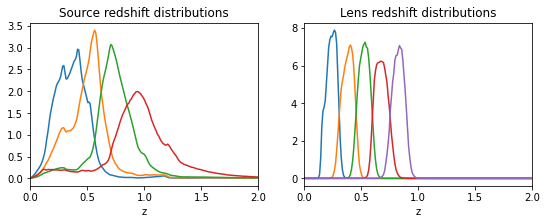

In [64]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
for i in range(4):
    plot(zs, nzs[i])
xlim(0,2); xlabel('z');
title('Source redshift distributions')
subplot(122)
for i in range(5):
    plot(zl, nzl[i])
xlim(0,2); xlabel('z');
title('Lens redshift distributions');

In [136]:
# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

# This is the bias from the 3x2pt paper
bias_l = [1.4, 1.6, 1.6, 1.9, 2.0]

# Define IA bias for DES Y1
def des_y1_ia_bias(z, A, eta, z0=0.62):
    """
    https://arxiv.org/pdf/1708.01538.pdf Sec. VII.B
    Parameters:
    -----------
    A: amplitude
    eta: redshift dependent slope
    z0: pivot redshift
    """
    return A * ((1.0 + z) / (1.0 + z0)) ** eta

In [343]:
# Build redsdhift distributions from jax-cosmo
# This nz will be used with very fine sampling for CCL, for consistency
nzs_s = [jc.redshift.kde_nz(zs.astype('float32'),
                        nzs[i].astype('float32'), 
                        bw=0.02,
                        gals_per_arcmin2=neff_s[i], zmax=3.)
       for i in range(4)]
nzs_l = [jc.redshift.kde_nz(zl.astype('float32'), nzl[i].astype('float32'), bw=0.02, zmax=1.)
       for i in range(5)]

zsamp = np.linspace(0.,4.,2048)

In [344]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.sigma8, cosmo.n_s, cosmo.w0, cosmo.wa,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = params[0:7]
    m1,m2,m3,m4 = params[7:11]
    dz1,dz2,dz3,dz4 = params[11:15]
    A = params[15]
    eta = params[16]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(array([ 0.2589,  0.0486,  0.6774,  0.8159,  0.9667, -1.    ,  0.    ]),
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [1.0, 2.0])

In [472]:
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.])

# And a range of ell values
ell = np.logspace(1,3)

## Defining CCL and jax-cosmo data vector computation

In [473]:
def ccl_3x2pt_mean(params):
    """
    This function returns the mean data vector provided a set of
    cosmological and nuisance parameters.
    """
    # Unpacking parameter vector
    cosmo_params, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # We define the cosmology
    cosmo_ccl = ccl.Cosmology(
        Omega_c=cosmo_params[0], Omega_b=cosmo_params[1],
        h=cosmo_params[2], sigma8=cosmo_params[3],
        n_s=cosmo_params[4], w0=cosmo_params[5],
        wa=cosmo_params[6], Neff=0, 
        transfer_function='eisenstein_hu', 
        matter_power_spectrum='halofit')
    
    # Build source nz with redshift systematic bias
    # Uses same function as jax-cosmo to ensure consistency
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # We build the tracers for each redshift bins
    tracers = [ccl.WeakLensingTracer(cosmo_ccl, (zsamp, nzs_s_sys[i](zsamp)),
                                     ia_bias=(zsamp, des_y1_ia_bias(zsamp, A, eta))) for i in range(4)]
    # And we keep track of a term for multiplicative biases, for shear only
    m_biases = [1.+m[i] for i in range(4)]
    tracers += [ccl.NumberCountsTracer(cosmo_ccl,
                                       has_rsd=False,
                                       dndz=(zsamp, nzs_l[i](zsamp)),
                                       bias=(zsamp, bias_l[i]*np.ones_like(zsamp))) for i in range(5)]
    m_biases += [1. for i in range(5)]
    n_tracers = len(tracers)
    
    # Compute all cross correlations
    cls = []
    for i in range(n_tracers):
        for j in range(i, n_tracers):
            cls.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell)*m_biases[i]*m_biases[j])

    return np.concatenate(cls)

In [474]:
ccl_mu = ccl_3x2pt_mean(fid_params)

In [365]:
%timeit ccl_3x2pt_mean(fid_params)

500 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [349]:
inds[30], inds[31], inds[32], inds[33], inds[34],inds[35]

((4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 5))

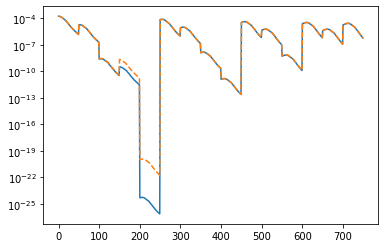

In [357]:
semilogy(ccl_mu[50*30:])
semilogy(jc_mu[50*30:],'--')

In [366]:
@jax.jit
def jc_3x2pt_mean(params):
    """
    This function computes the mean signal of a 3x2pt analysis using
    jax-cosmo
    """
    # First unpack parameter vector
    cosmo_params, m, dz, (A, eta) = unpack_params_vec(params) 

    # Define cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=cosmo_params[1],
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4], w0=cosmo_params[5],
                         Omega_k=0., wa=cosmo_params[6])
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias_l] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

In [455]:
jc_mu = jc_3x2pt_mean(fid_params)
%timeit jc_3x2pt_mean(fid_params).block_until_ready()

347 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(1e-14, 0.001)

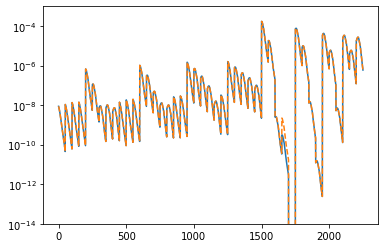

In [476]:
semilogy(abs(ccl_mu))
semilogy(abs(jc_mu),'--')
ylim(1e-14,1e-3)

And finally, we use jax-cosmo to compute the covariance matrix for this survey at the fiducial cosmology

In [477]:
def gaussian_covariance(params):
    """
    This function computes the Gaussian covariance for a 3x2pt
    """
    # First unpack parameter vector
    cosmo_params, m, dz, (A, eta) = unpack_params_vec(params) 

    # Define cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=cosmo_params[1],
                         h=cosmo_params[2],
                         sigma8=cosmo_params[3], 
                         n_s=cosmo_params[4], w0=cosmo_params[5],
                         Omega_k=0., wa=cosmo_params[6])
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias_l] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25, sparse=False)
    
    return cov

cov_mat = gaussian_covariance(fid_params)
prc_mat = np.linalg.inv(cov_mat)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.num

## Jacobian computation

Now  that we have functions to compute the mean, let's compute the 
Jacobians, using finite differences for CCL, and autodiff for jax-cosmo

In [373]:
import numdifftools as nd

In [374]:
# Defining CCL jacobian
ccl_3x2pt_jac = nd.Jacobian(ccl_3x2pt_mean, step=0.002)

In [375]:
ccl_J = ccl_3x2pt_jac(fid_params)
%timeit ccl_3x2pt_jac(fid_params)

28.8 s ± 2.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [376]:
# Defining jax-cosmo jacobian
jc_3x2pt_jac = jax.jit(jax.jacfwd(jc_3x2pt_mean))

In [377]:
jc_J = jc_3x2pt_jac(fid_params)
%timeit jc_3x2pt_jac(fid_params).block_until_ready()

3.05 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


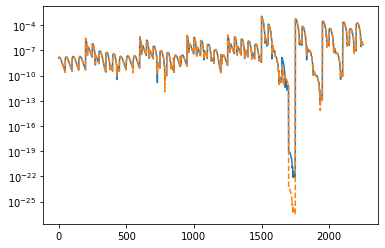

In [393]:
# Quick comparison
semilogy(abs(jc_J[:,0]))
semilogy(abs(ccl_J[:,0]),'--')

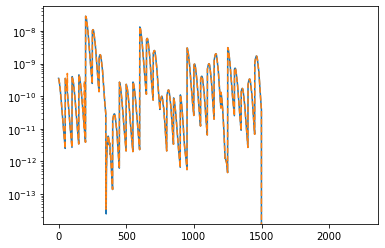

In [434]:
# Test IA derivatives
semilogy(abs(jc_J[:,-1]))
semilogy(abs(ccl_J[:,-1]),'--')

In [437]:
# Computing Fisher matrices
jc_F = jc_J.T @ prc_mat @ jc_J
ccl_F = ccl_J.T @ prc_mat @ ccl_J

In [438]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip

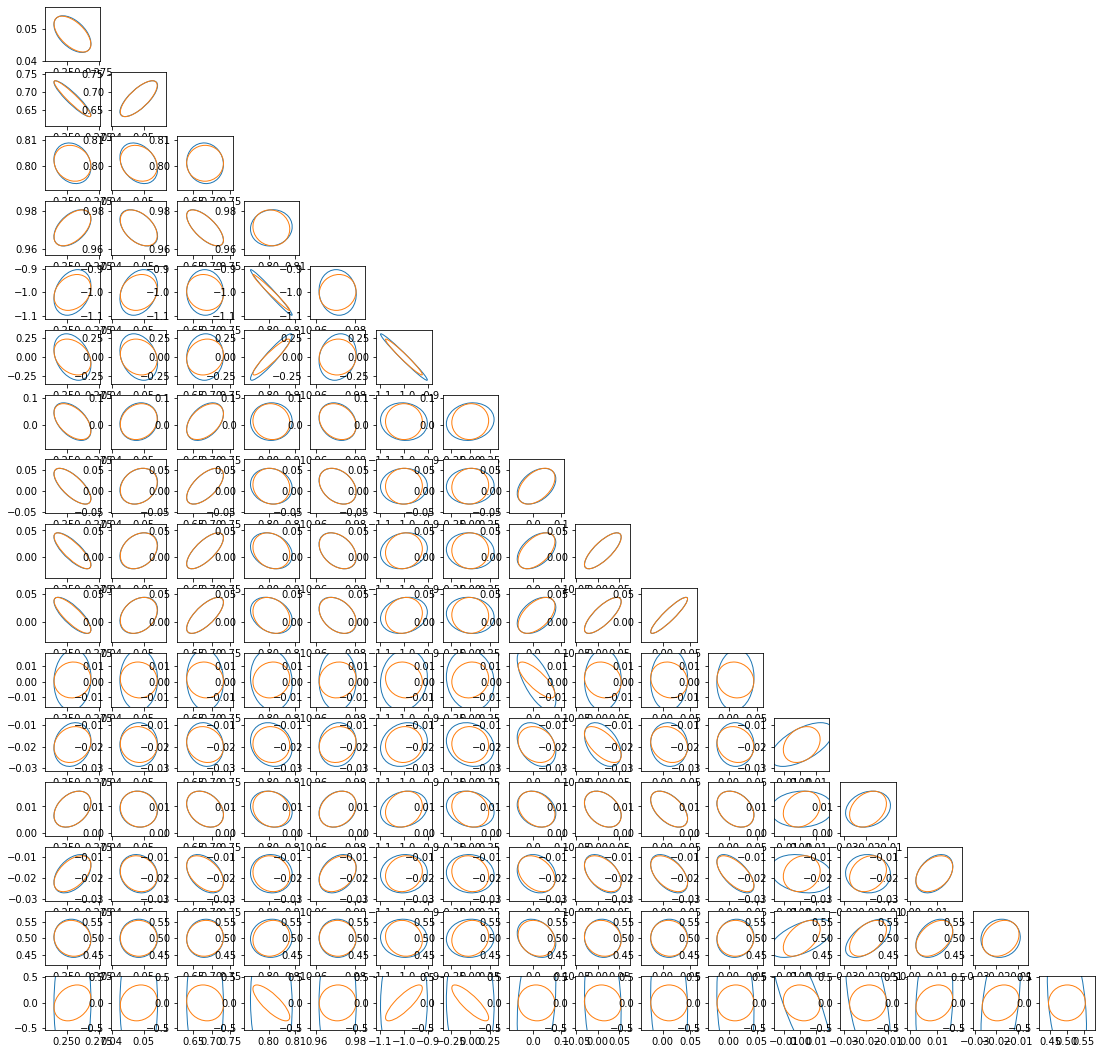

In [426]:
figure(figsize=(20, 20))

for i in range(17):
    for j in range(17):
        if j<i:
            subplot(17,17,i*17+j+1)
            plot_contours(jc_F, fid_params, [j,i],fill=False,color='C0')
            plot_contours(ccl_F, fid_params, [j,i],fill=False,color='C1')

In [487]:
ccl_3x2pt_jac = nd.Jacobian(ccl_3x2pt_mean, step=0.001)
ccl_J = ccl_3x2pt_jac(fid_params)

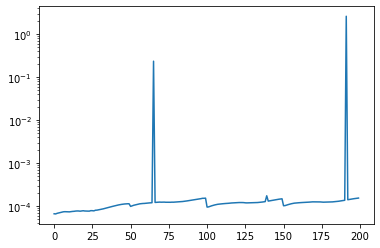

In [490]:
semilogy((abs(ccl_J[:,-1] - jc_J[:,-1])/jc_mu)[:4*50])

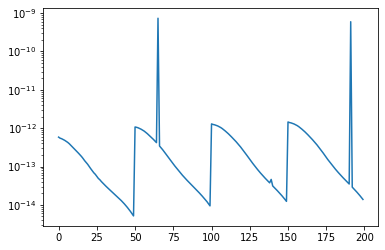

In [491]:
semilogy((abs(ccl_J[:,-1] - jc_J[:,-1]))[:4*50])

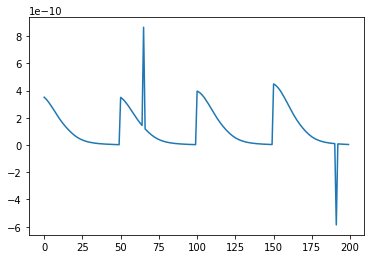

In [492]:
plot(ccl_J[:,-1][:4*50])

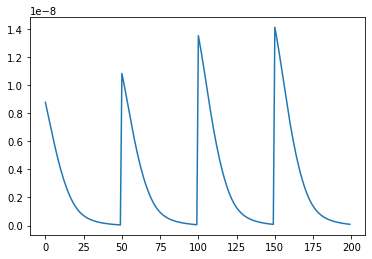

In [497]:
plot(ccl_mu[:4*50])

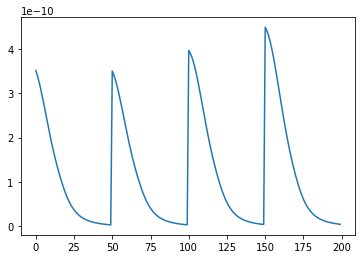

In [493]:
plot(jc_J[:,-1][:4*50])

In [494]:
ccl_F = ccl_J.T @ prc_mat @ ccl_J

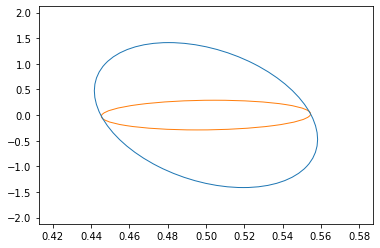

In [495]:
plot_contours(ccl_F, fid_params, [15,16], fill=False, color='C1')
plot_contours(jc_F, fid_params, [15,16], fill=False, color='C0')

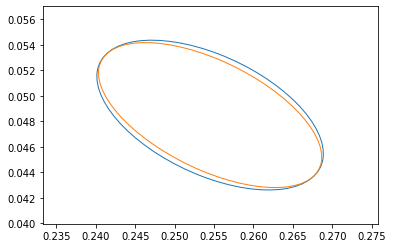

In [496]:
plot_contours(jc_F, fid_params, [0,1],fill=False,color='C0')
plot_contours(ccl_F, fid_params, [0,1],fill=False,color='C1')